In [1]:
%pip install scipy==1.12
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 58.7 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 45.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 57.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 36.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Version simple présenté sur le site de Kaggle (vecteurs à 2 dimensions)

MMD result of X and Y is 0.392077773809433


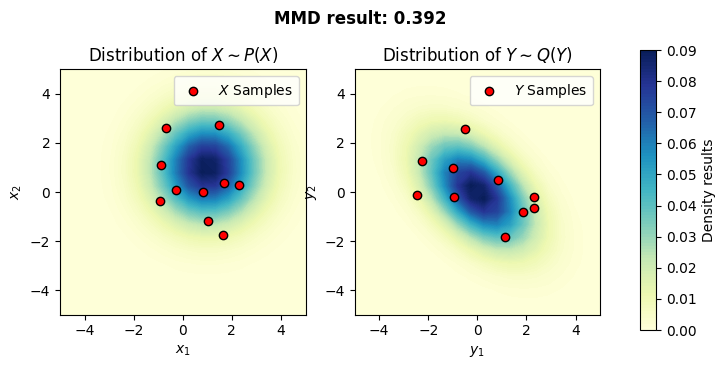

In [21]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)
    

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet 
from torch.distributions.multivariate_normal import MultivariateNormal 


m = 20 # sample size
x_mean = torch.zeros(2)+1
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3*torch.eye(2) - 1

px = MultivariateNormal(x_mean, x_cov)

qy = MultivariateNormal(y_mean, y_cov)
x = px.sample([m]).to(device)
#print(x)
y = qy.sample([m]).to(device)

result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")

# ---- Plotting setup ----

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), dpi=100)
#plt.tight_layout() 
delta = 0.025

x1_val = np.linspace(-5, 5, num=m)
x2_val = np.linspace(-5, 5, num=m)
x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = torch.zeros(m,m)
qy_grid = torch.zeros(m,m)


for i in range(m):
    for j in range(m):
        px_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], x_mean, x_cov)
        qy_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], y_mean, y_cov)


CS1 = ax1.contourf(x1, x2, px_grid,100, cmap=plt.cm.YlGnBu)
ax1.set_title(r"Distribution of $X \sim P(X)$")
ax1.set_ylabel('$x_2$')
ax1.set_xlabel('$x_1$')
ax1.set_aspect('equal')
ax1.scatter(x[:10,0].cpu(), x[:10,1].cpu(), label="$X$ Samples", marker="o", facecolor="r", edgecolor="k")
ax1.legend()

CS2 = ax2.contourf(x1, x2, qy_grid,100, cmap=plt.cm.YlGnBu)
ax2.set_title(r"Distribution of $Y \sim Q(Y)$")
ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_aspect('equal')
ax2.scatter(y[:10,0].cpu(), y[:10,1].cpu(), label="$Y$ Samples", marker="o", facecolor="r", edgecolor="k")
ax2.legend()
#ax1.axis([-2.5, 2.5, -2.5, 2.5])

# Add colorbar and title
fig.subplots_adjust(right=0.8)


cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS2, cax=cbar_ax)
cbar.ax.set_ylabel('Density results')
plt.suptitle(f"MMD result: {round(result.item(),3)}",y=0.95, fontweight="bold")
plt.show()



## We want to we want to check if the distance is indeed 0 for 2 same distributions


MMD result of X and Y is 0.007288265973329544


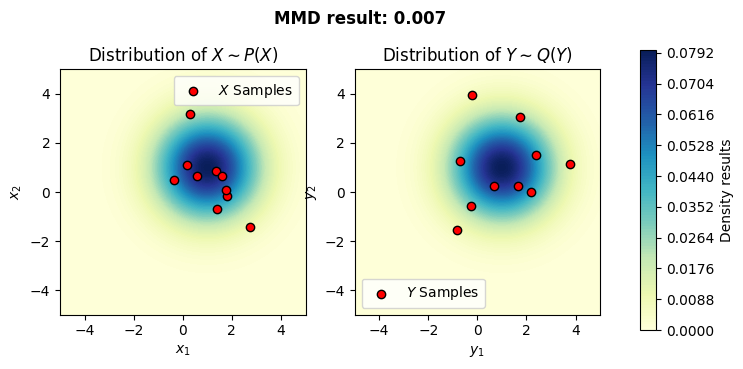

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)
    

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet 
from torch.distributions.multivariate_normal import MultivariateNormal 


m = 1000 # sample size
x_mean = torch.zeros(2)+1
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3*torch.eye(2) - 1

px = MultivariateNormal(x_mean, x_cov)
qy = MultivariateNormal(x_mean, x_cov)
x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)

result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")

# ---- Plotting setup ----

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), dpi=100)
#plt.tight_layout() 
delta = 0.025

x1_val = np.linspace(-5, 5, num=m)
x2_val = np.linspace(-5, 5, num=m)
x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = torch.zeros(m,m)
qy_grid = torch.zeros(m,m)


for i in range(m):
    for j in range(m):
        px_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], x_mean, x_cov)
        qy_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], x_mean, x_cov)



# Faute de place, on affiche uniquement les 10 premiers points sur les graphes 


CS1 = ax1.contourf(x1, x2, px_grid,100, cmap=plt.cm.YlGnBu)
ax1.set_title(r"Distribution of $X \sim P(X)$")
ax1.set_ylabel('$x_2$')
ax1.set_xlabel('$x_1$')
ax1.set_aspect('equal')
ax1.scatter(x[:10,0].cpu(), x[:10,1].cpu(), label="$X$ Samples", marker="o", facecolor="r", edgecolor="k")
ax1.legend()

CS2 = ax2.contourf(x1, x2, qy_grid,100, cmap=plt.cm.YlGnBu)
ax2.set_title(r"Distribution of $Y \sim Q(Y)$")
ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_aspect('equal')
ax2.scatter(y[:10,0].cpu(), y[:10,1].cpu(), label="$Y$ Samples", marker="o", facecolor="r", edgecolor="k")
ax2.legend()
#ax1.axis([-2.5, 2.5, -2.5, 2.5])

# Add colorbar and title
fig.subplots_adjust(right=0.8)


cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS2, cax=cbar_ax)
cbar.ax.set_ylabel('Density results')
plt.suptitle(f"MMD result: {round(result.item(),3)}",y=0.95, fontweight="bold")
plt.show()



## Indeed, when the sample tend to infinite, (for instance with 100 or 1000), the value of the distance is tending to 0. For sample higher then 100, dont try to show the graphic because it will freeze

# New Test but with larger vector (10 dimensions) 

In [2]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Empirical maximum mean discrepancy. The lower the result,
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx  # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy  # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz  # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)

    return torch.mean(XX + YY - 2. * XY)

# Sample size
m = 20

# Generate data
x_mean = torch.zeros(10) + 1
y_mean = torch.zeros(10)

# Properly defined positive definite covariance matrices
x_cov = 2 * torch.eye(10)  # Covariance matrix for X
y_cov = 2 * torch.eye(10)  # Different positive definite covariance matrix for Y

# Distributions
px = torch.distributions.MultivariateNormal(x_mean, x_cov)
qy = torch.distributions.MultivariateNormal(y_mean, y_cov)


# Generate samples
x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)

print(x)

# Calculate MMD
result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")


tensor([[ 0.5176, -0.1526,  1.1153, -2.7603, -0.5345,  2.6981,  1.7114,  1.1825,
          2.2716, -0.2942],
        [-0.5025,  1.2349,  0.4010,  1.8917,  1.6833,  0.9195, -1.1569,  1.8929,
         -0.0920,  1.2872],
        [ 2.5609, -0.2747, -0.3781,  0.5319,  1.3726,  3.6672,  0.1640, -0.3106,
          0.5943, -0.3649],
        [ 1.6276,  0.0484, -0.2525,  2.1168,  1.8645, -0.0902,  3.5242,  1.7597,
         -0.8805,  0.3373],
        [-2.1559,  2.4383,  4.0257, -0.6944,  2.5918,  0.3273,  0.3592, -1.0301,
          1.7640,  0.9948],
        [ 2.1820,  2.3623,  1.8601,  2.2395,  0.5269,  0.6429,  0.5945,  2.0914,
          1.2946,  0.5438],
        [ 2.1463,  3.0045,  2.2591,  1.3239, -1.0786, -0.0735, -0.4214, -0.1763,
          1.7869, -0.6432],
        [ 2.0262,  0.7540, -1.6046,  1.4684,  1.8514,  0.5535,  1.7098,  0.8409,
          1.2579,  2.1579],
        [ 0.9122,  2.6025,  1.0243,  0.6082,  1.0504,  0.1002, -1.0647,  1.4930,
          1.1327, -0.6540],
        [ 1.5915,  

## Same for identical vectors 

In [18]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Empirical maximum mean discrepancy. The lower the result,
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx  # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy  # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz  # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)

    return torch.mean(XX + YY - 2. * XY)

# Sample size
m = 10000

# Generate data
x_mean = torch.zeros(10) + 1
y_mean = torch.zeros(10)

# Properly defined positive definite covariance matrices
x_cov = 2 * torch.eye(10)  # Covariance matrix for X
y_cov = 2 * torch.eye(10)  # Different positive definite covariance matrix for Y

# Distributions
px = torch.distributions.MultivariateNormal(x_mean, x_cov)
qy = torch.distributions.MultivariateNormal(x_mean, x_cov)

# Generate samples
x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)

# Calculate MMD
result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")


MMD result of X and Y is 0.0007990764570422471


# Offline Clustering Algorithm with MMD Distance

In [3]:
import numpy as np
import torch

def MMD(x, y, kernel):
    """Empirical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    device = x.device  # Assure que le device est bien utilisé dans la fonction
    
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx  # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy  # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz  # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
    
    return torch.mean(XX + YY - 2. * XY)

def initialize_clusters(data, k, kernel, device='cpu'):
    N = len(data)
    clusters = {i: [] for i in range(k)}
    centers = [data[0]]
    clusters[0].append(0)

    # Convert data to tensor for MMD function
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    for cluster_idx in range(1, k):
        max_mmd = -np.inf
        new_center_idx = -1
        for i in range(N):
            if any(i in cluster for cluster in clusters.values()):
                continue
            # Calculate the MMD distance from the current point to all existing centers
            mmd_dist = max([MMD(data_tensor[i:i+1], torch.tensor([centers[j]], dtype=torch.float32).to(device), kernel).item() for j in range(len(centers))])
            if mmd_dist > max_mmd:
                max_mmd = mmd_dist
                new_center_idx = i
        centers.append(data[new_center_idx])
        clusters[cluster_idx].append(new_center_idx)

    return centers, clusters

def assign_points_to_clusters(data, centers, clusters, kernel, device='cpu'):
    N = len(data)
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    for i in range(N):
        if any(i in cluster for cluster in clusters.values()):
            continue
        # Calculate the MMD distance from the current point to all centers
        closest_center_idx = np.argmin([MMD(data_tensor[i:i+1], torch.tensor([center], dtype=torch.float32).to(device), kernel).item() for center in centers])
        clusters[closest_center_idx].append(i)
    return clusters

def offline_clustering(data, k, kernel="rbf", device='cpu'):
    centers, clusters = initialize_clusters(data, k, kernel, device)
    clusters = assign_points_to_clusters(data, centers, clusters, kernel, device)
    return clusters

# Test the algorithm
def test_offline_clustering():
    # np.random.seed(0)
    # data = np.random.rand(10, 2)
    # 3 vecteurs générés par une loi gaussienne avec moyenne 2 et ecart type 1 
    gaussian_data3 = np.random.normal(loc=2, scale=1, size=(10, 10))
    print(gaussian_data3)
    

    # 3 vecteurs générés par une loi gaussienne avec moyenne 0 et écart type 1
    gaussian_data1 = np.random.normal(loc=0, scale=1, size=(10, 10))

    # 4 vecteurs générés par une autre loi gaussienne avec moyenne 5 et écart type 2
    gaussian_data2 = np.random.normal(loc=5, scale=5, size=(10, 10))

    # Concaténer tous les vecteurs pour former le jeu de données complet
    data = np.concatenate((gaussian_data3, gaussian_data1, gaussian_data2), axis=0)
    #print(data)
    k = 3

    clusters = offline_clustering(data, k, kernel="rbf", device='cpu')

    for cluster_idx, points in clusters.items():
        print(f"Cluster {cluster_idx}: {points}")

test_offline_clustering()


[[ 0.62238055  1.60803874  3.49854457 -0.1674301   2.67691621  2.26511328
   2.34064441  3.88113986  2.55220261  3.52961738]
 [ 1.45308621  1.59702054  2.00520269  3.32546308  1.32669659  0.50343541
   2.53461298 -0.1209601   0.53330106  1.17058283]
 [ 3.04028913  1.30716607  1.29685715  1.61054721  1.2356736   3.39280181
   1.95390555  3.31000843  2.47543372  3.41067821]
 [ 1.61555474  3.07055848  2.2795665   1.97166146  2.93976216  2.49892393
   2.15845295  1.61066261  2.12811941  2.0396924 ]
 [ 1.98893379  2.91893708  2.94824996  2.01879273  1.64041731  2.30786575
   2.07908638  2.36632458  0.47314331  1.04206407]
 [ 3.70578532  1.7270912   0.67031743  1.77048007  2.32120361  3.95826792
   0.92735908  2.50831593  1.73535244  0.72980404]
 [ 1.89944942  2.99977099  2.32145045  2.32917873  1.2581667   1.65736603
   1.43929325  2.21112978  1.57945432  1.71223833]
 [ 3.17460934  1.61012807  3.69760086  0.23611832  1.49611337  3.32605292
  -0.38000018  1.57912051  0.69074961  2.9515139 ]


/tmp/ipykernel_133/4219033703.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  mmd_dist = max([MMD(data_tensor[i:i+1], torch.tensor([centers[j]], dtype=torch.float32).to(device), kernel).item() for j in range(len(centers))])


Cluster 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 22, 23, 24, 25, 26, 28, 29]
Cluster 1: [21, 27]
Cluster 2: [12, 10, 11, 13, 14, 15, 16, 17, 18, 19]
